In [40]:
import matplotlib.pyplot as plt
import numpy as np
from random import uniform
from shapely.geometry import Point, Polygon
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import itertools

In [41]:
class CreateData:
    def __init__(self, points=500):
        self.points = points

    def random_points(self, poly):
        minx, miny, maxx, maxy = poly.bounds
        while True:
            p = Point(uniform(minx, maxx), uniform(miny, maxy))
            if poly.contains(p):
                return p

    def polar_point(self, origin_point, angle,  distance):
        return [origin_point.x + math.sin(math.radians(angle)) * distance, origin_point.y + math.cos(math.radians(angle)) * distance]

    def sector(self, center, start_angle, end_angle, radius, steps=200):
        step_angle_width = (end_angle-start_angle) / steps
        sector_width = (end_angle-start_angle) 
        segment_vertices = []

        segment_vertices.append(self.polar_point(center, 0,0))
        segment_vertices.append(self.polar_point(center, start_angle,radius))

        for i in range(1, steps):
            segment_vertices.append((self.polar_point(center, start_angle + i * step_angle_width,radius)))
        segment_vertices.append(self.polar_point(center, start_angle+sector_width,radius))
        segment_vertices.append(self.polar_point(center, 0,0))
        return Polygon(segment_vertices)

    def create_samples_labels(self):
        polygons = [Polygon([(0, 0), (1, 0), (0, 1), (0, 0)]), Polygon([(0, 0), (-1, 0), (0, 1), (0, 0)]), 
                    Polygon([(0, 0), (-1, 0), (0, -1), (0, 0)]), Polygon([(0, 0), (1, 0), (0, -1), (0, 0)])]
        polygon_points = [[] for _ in polygons]

        for i in range(self.points):
            for j in range(len(polygons)):
                polygon_points[j].append(self.random_points(polygons[j]))

        center = Point(0,0)
        sectors = [self.sector(center, 0, 90, 1), self.sector(center, 0, -90, 1), self.sector(center, 180, 270, 1), self.sector(center, 180, 90, 1)]
        sector_points = [[] for _ in sectors]

        for i in range(self.points):
            for j in range(len(sectors)):
                sector_points[j].append(self.random_points(sectors[j].difference(polygons[j])))

        samples = []
        labels = []

        for i in range(self.points):
            for j in range(len(polygons)):
                samples.append([polygon_points[j][i].x, polygon_points[j][i].y])
                labels.append([int(k==j) for k in range(len(polygons))])
            for j in range(len(sectors)):
                samples.append([sector_points[j][i].x, sector_points[j][i].y])
                labels.append([int(k==j+len(polygons)) for k in range(len(polygons)+len(sectors))])

        max_sample_length = max(len(sample) for sample in samples)
        max_label_length = max(len(label) for label in labels)

        samples = [sample + [0]*(max_sample_length - len(sample)) for sample in samples]
        labels = [label + [0]*(max_label_length - len(label)) for label in labels]

        return np.array(samples), np.array(labels)

In [42]:
generator = CreateData(points=500)
samples, labels = generator.create_samples_labels()

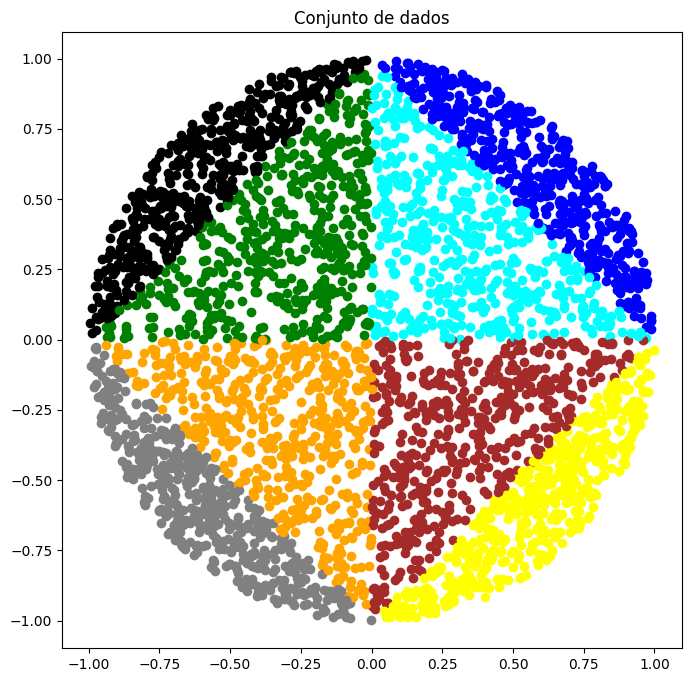

In [45]:
c1Points = samples[np.where(np.all(labels == [1, 0, 0, 0, 0, 0, 0, 0], axis=1))]
c2Points = samples[np.where(np.all(labels == [0, 1, 0, 0, 0, 0, 0, 0], axis=1))]
c3Points = samples[np.where(np.all(labels == [0, 0, 1, 0, 0, 0, 0, 0], axis=1))]
c4Points = samples[np.where(np.all(labels == [0, 0, 0, 1, 0, 0, 0, 0], axis=1))]
c5Points = samples[np.where(np.all(labels == [0, 0, 0, 0, 1, 0, 0, 0], axis=1))]
c6Points = samples[np.where(np.all(labels == [0, 0, 0, 0, 0, 1, 0, 0], axis=1))]
c7Points = samples[np.where(np.all(labels == [0, 0, 0, 0, 0, 0, 1, 0], axis=1))]
c8Points = samples[np.where(np.all(labels == [0, 0, 0, 0, 0, 0, 0, 1], axis=1))]


plt.figure(figsize=(8,8))
plt.title('Conjunto de dados')
for i in range(generator.points):
    plt.scatter(c1Points[i, 0], c1Points[i, 1], color='cyan')
    plt.scatter(c2Points[i, 0], c2Points[i, 1], color='green')
    plt.scatter(c3Points[i, 0], c3Points[i, 1], color='orange')
    plt.scatter(c4Points[i, 0], c4Points[i, 1], color='brown')
    plt.scatter(c5Points[i, 0], c5Points[i, 1], color='blue')
    plt.scatter(c6Points[i, 0], c6Points[i, 1], color='black')
    plt.scatter(c7Points[i, 0], c7Points[i, 1], color='grey')
    plt.scatter(c8Points[i, 0], c8Points[i, 1], color='yellow')
plt.show()


In [5]:
train_samples, test_samples, train_labels, test_labels = train_test_split(samples, labels, test_size=0.2, random_state=45)

In [6]:
train_samples.shape
train_labels.shape

(3200, 8)

## Regra Delta Convencional

In [7]:
model_convencional = Sequential([
    Dense(units=16, input_shape=(2,), activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=8, activation='softmax'),
])

In [8]:
model_convencional.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
result_convencional= model_convencional.fit(x=train_samples, y=train_labels, validation_split=0.1, batch_size=22, epochs=50, shuffle=True, verbose=2)

Epoch 1/50
131/131 - 1s - loss: 0.9118 - accuracy: 0.6316 - val_loss: 0.5211 - val_accuracy: 0.7625 - 910ms/epoch - 7ms/step
Epoch 2/50
131/131 - 0s - loss: 0.3728 - accuracy: 0.8559 - val_loss: 0.3119 - val_accuracy: 0.8562 - 202ms/epoch - 2ms/step
Epoch 3/50
131/131 - 0s - loss: 0.2595 - accuracy: 0.8972 - val_loss: 0.2010 - val_accuracy: 0.9187 - 168ms/epoch - 1ms/step
Epoch 4/50
131/131 - 0s - loss: 0.2014 - accuracy: 0.9240 - val_loss: 0.1772 - val_accuracy: 0.9312 - 184ms/epoch - 1ms/step
Epoch 5/50
131/131 - 0s - loss: 0.1695 - accuracy: 0.9389 - val_loss: 0.1671 - val_accuracy: 0.9312 - 193ms/epoch - 1ms/step
Epoch 6/50
131/131 - 0s - loss: 0.1647 - accuracy: 0.9340 - val_loss: 0.1271 - val_accuracy: 0.9625 - 197ms/epoch - 2ms/step
Epoch 7/50
131/131 - 0s - loss: 0.1585 - accuracy: 0.9365 - val_loss: 0.1655 - val_accuracy: 0.9375 - 231ms/epoch - 2ms/step
Epoch 8/50
131/131 - 0s - loss: 0.1758 - accuracy: 0.9264 - val_loss: 0.1257 - val_accuracy: 0.9469 - 180ms/epoch - 1ms/step


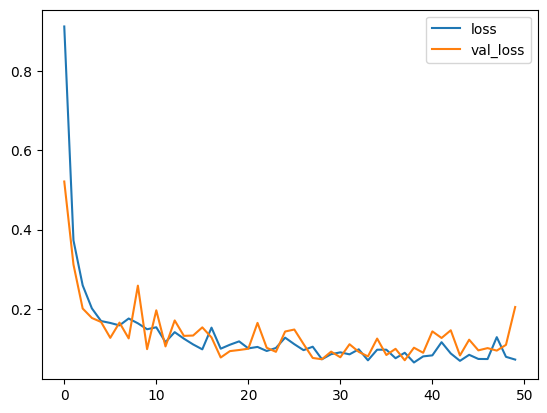

In [10]:
plt.plot(result_convencional.history['loss'], label='loss')
plt.plot(result_convencional.history['val_loss'], label='val_loss')
plt.legend()

In [11]:
predictions_convencional = model_convencional.predict(x=test_samples, batch_size=22,verbose=0)
rounded_predictions_convencional = np.argmax(predictions_convencional, axis=-1)
accuracy_score(rounded_predictions_convencional, np.argmax(test_labels, axis=-1))

0.935

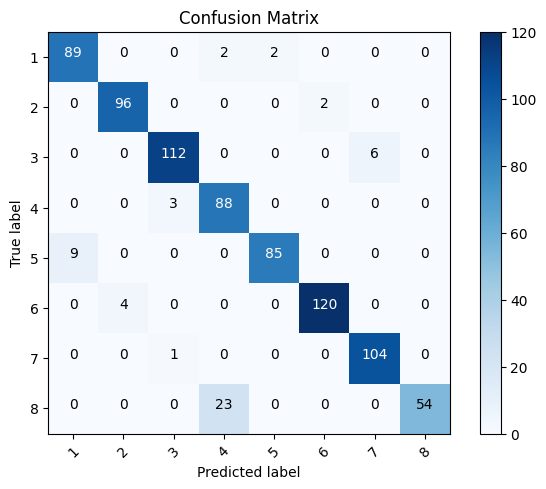

In [22]:
cm = confusion_matrix(np.argmax(test_labels, axis=-1), rounded_predictions_convencional)

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm_plot_labels = ['1', '2', '3', '4', '5', '6', '7', '8']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

plt.show()



## Regra Delta com Termo do Momento

In [33]:
model_momento = Sequential([
    Dense(units=16, input_shape=(2,), activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=8, activation='softmax'),
])

In [34]:
#beta_1 é o parâmetro do termo do momento
model_momento.compile(optimizer=Adam(learning_rate=0.01, beta_1=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
result_momento = model_momento.fit(x=train_samples, y=train_labels, validation_split=0.1, batch_size=22, epochs=50, shuffle=True, verbose=2)

Epoch 1/50
131/131 - 1s - loss: 0.8651 - accuracy: 0.6448 - val_loss: 0.4523 - val_accuracy: 0.8094 - 691ms/epoch - 5ms/step
Epoch 2/50
131/131 - 0s - loss: 0.3282 - accuracy: 0.8851 - val_loss: 0.2905 - val_accuracy: 0.8719 - 180ms/epoch - 1ms/step
Epoch 3/50
131/131 - 0s - loss: 0.2239 - accuracy: 0.9174 - val_loss: 0.1758 - val_accuracy: 0.9375 - 168ms/epoch - 1ms/step
Epoch 4/50
131/131 - 0s - loss: 0.1984 - accuracy: 0.9201 - val_loss: 0.1681 - val_accuracy: 0.9312 - 183ms/epoch - 1ms/step
Epoch 5/50
131/131 - 0s - loss: 0.2218 - accuracy: 0.9073 - val_loss: 0.1365 - val_accuracy: 0.9500 - 209ms/epoch - 2ms/step
Epoch 6/50
131/131 - 0s - loss: 0.1574 - accuracy: 0.9337 - val_loss: 0.1540 - val_accuracy: 0.9344 - 197ms/epoch - 2ms/step
Epoch 7/50
131/131 - 0s - loss: 0.1571 - accuracy: 0.9372 - val_loss: 0.1201 - val_accuracy: 0.9688 - 186ms/epoch - 1ms/step
Epoch 8/50
131/131 - 0s - loss: 0.1556 - accuracy: 0.9438 - val_loss: 0.1250 - val_accuracy: 0.9500 - 173ms/epoch - 1ms/step


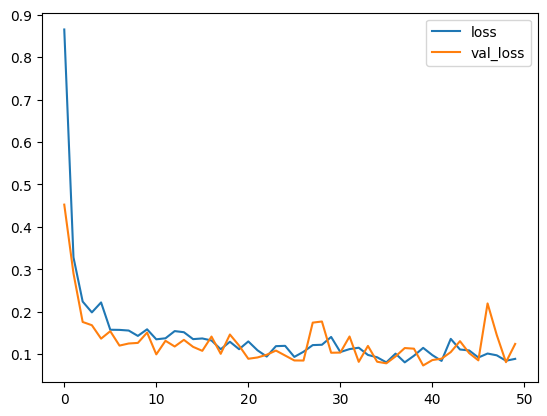

In [36]:
plt.plot(result_momento.history['loss'], label='loss')
plt.plot(result_momento.history['val_loss'], label='val_loss')
plt.legend()

In [37]:
prediction_momento = model_momento.predict(x=test_samples, batch_size=22,verbose=0)
rounded_prediction_momento = np.argmax(prediction_momento, axis=-1)
accuracy_score(rounded_prediction_momento, np.argmax(test_labels, axis=-1))

0.95125

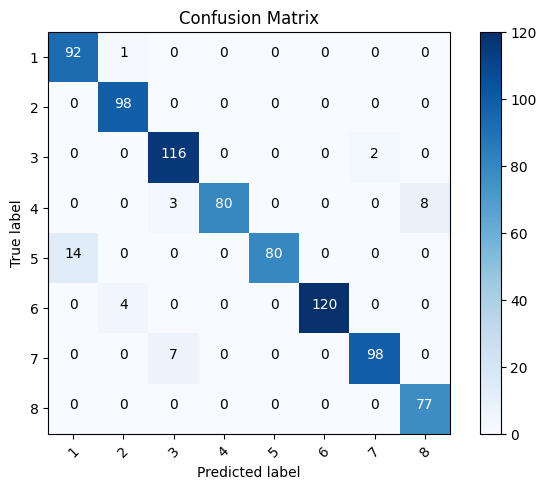

In [38]:
cm = confusion_matrix(np.argmax(test_labels, axis=-1), rounded_prediction_momento)

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm_plot_labels = ['1', '2', '3', '4', '5', '6', '7', '8']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

plt.show()

